In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Caminhos para as pastas de treino e teste
TRAIN_PATH = '/content/drive/MyDrive/dataset/train_dataset'
TEST_PATH = '/content/drive/MyDrive/dataset_pivot/teste'

# Hiperparâmetros
WIDTH, HEIGHT = 256, 256
CHANNELS = 3
BATCH_SIZE = 128
EPOCHS = 50

In [ ]:
# Função para carregar imagens de uma pasta e transformá-las em arrays numpy com rótulos
def load_images_from_folder(folder, label):
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.png'):
            img = Image.open(img_path).convert('RGB')
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

# Carregar imagens das classes "pivot" e "not pivot" do conjunto de treino
pivo_images, pivo_labels = load_images_from_folder(os.path.join(TRAIN_PATH, 'pivot'), label=1)
nao_pivo_images, nao_pivo_labels = load_images_from_folder(os.path.join(TRAIN_PATH, 'not_pivot'), label=0)

# Combinar as imagens e rótulos de ambas as classes
X_train_data = np.array(pivo_images + nao_pivo_images)
y_train_data = np.array(pivo_labels + nao_pivo_labels)

# Verificar as formas dos arrays
print(f'Train dataset shape: {X_train_data.shape}')
print(f'Train labels shape: {y_train_data.shape}')

# Salvar o dataset de treino em um arquivo .npz
np.savez('/content/drive/MyDrive/dataset_pivot/dataset_pivot_train.npz', X=X_train_data, y=y_train_data.reshape(-1, 1))

# Repetir o mesmo processo para o conjunto de teste
pivo_images_test, pivo_labels_test = load_images_from_folder(os.path.join(TEST_PATH, 'pivot'), label=1)
nao_pivo_images_test, nao_pivo_labels_test = load_images_from_folder(os.path.join(TEST_PATH, 'not_pivot'), label=0)

X_test_data = np.array(pivo_images_test + nao_pivo_images_test)
y_test_data = np.array(pivo_labels_test + nao_pivo_labels_test)

print(f'Test dataset shape: {X_test_data.shape}')
print(f'Test labels shape: {y_test_data.shape}')

np.savez('/content/drive/MyDrive/dataset_pivot/dataset_pivot_test.npz', X=X_test_data, y=y_test_data.reshape(-1, 1))

Train dataset shape: (2516, 256, 256, 3)
Train labels shape: (2516,)
Test dataset shape: (60, 256, 256, 3)
Test labels shape: (60,)


In [ ]:
data = np.load('/content/drive/MyDrive/dataset_pivot/dataset_pivot_train.npz')
X = data['X']
y = data['y']

# Configuração do ImageDataGenerator para treinamento e validação
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Divida os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Criação dos geradores de dados
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

In [ ]:
# Definição da CNN
cnn = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(WIDTH, HEIGHT, CHANNELS)),
    MaxPooling2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(units=2048, activation='relu'),
    Dropout(0.5),
    Dense(units=1024, activation='relu'),
    Dropout(0.5),
    Dense(units=512, activation='relu'),
    Dropout(0.5),
    Dense(units=1, activation='sigmoid')
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │      33,556,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,468,161 (162.00 MB)

 Trainable params: 42,468,161 (162.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback para salvar os pesos do modelo a cada época
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/dataset_pivot/model_weight_epoch/epoch_{epoch:02d}.weights.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_freq='epoch'
)

# Treinamento do modelo
history = cnn.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)

# Salvar o modelo completo após o treinamento
cnn.save('/content/drive/MyDrive/dataset_pivot/model.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.6512 - loss: 0.9884 - val_accuracy: 0.7520 - val_loss: 0.5773
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6982 - loss: 0.6288 - val_accuracy: 0.7520 - val_loss: 0.5740
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7294 - loss: 0.5880 - val_accuracy: 0.7520 - val_loss: 0.5115
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7215 - loss: 0.5329 - val_accuracy: 0.7619 - val_loss: 0.4266
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7845 - loss: 0.4764 - val_accuracy: 0.8651 - val_loss: 0.4895
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8149 - loss: 0.4494 - val_accuracy: 0.8671 - val_loss: 0.3402
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8407 - loss: 0.3807 - val_accuracy: 0.8988 - val_loss: 0.3041
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8715 - loss: 0.3223 - val_accuracy: 0.8750 - val_loss: 0.3432
Ep

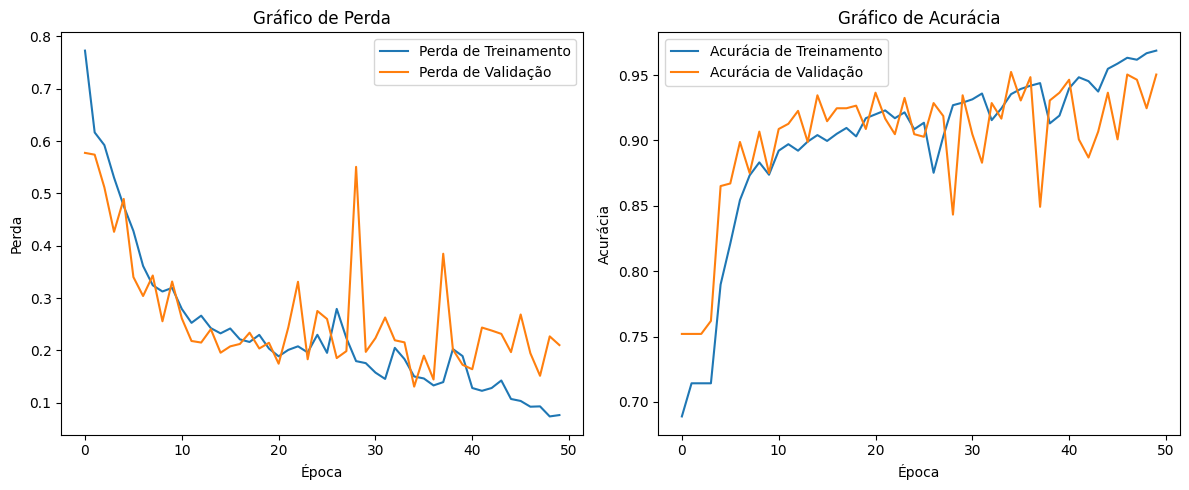

In [ ]:
# Plotar gráficos de perda e acurácia
plt.figure(figsize=(12, 5))

# Gráfico de perda
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.title('Gráfico de Perda')

# Gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Gráfico de Acurácia')

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.82      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

AUC: 0.9542


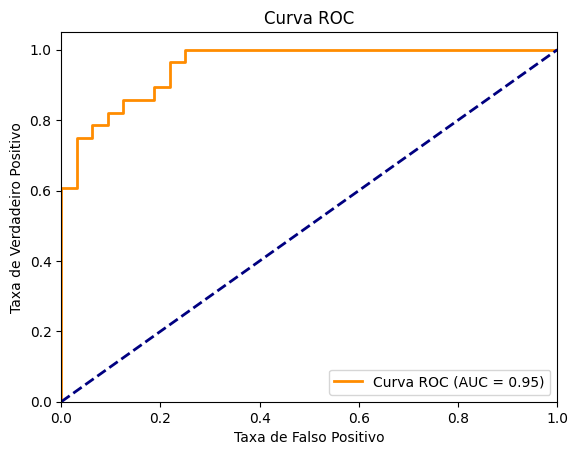

In [ ]:
# Carregar os dados de teste salvos anteriormente
test_data = np.load('/content/drive/MyDrive/dataset_pivot/dataset_pivot_test.npz')
X_test = test_data['X'] * (1./255)
y_test = test_data['y']

# Carregar o melhor peso salvo
cnn.load_weights('/content/drive/MyDrive/dataset_pivot/model_weight_epoch/weights_epoch_50.h5')

# Previsão dos rótulos
y_pred_prob = cnn.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calcular e exibir o relatório de classificação e a AUC
print("Classification Report:")
print(classification_report(y_test, y_pred))
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc_score:.4f}")

# Plotar a Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()




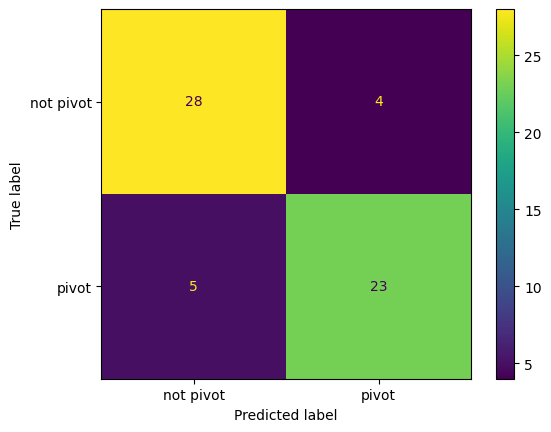

In [ ]:
# Plotar a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not pivot', 'pivot'])
disp.plot()
plt.show()